In [67]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, random_split
import torchaudio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from torchinfo import summary
import torch.nn.functional as F
from torch.nn import init
import os
from model_configs import ModelDimConfigs, TrainingConfigs
from misc_tools import get_timestamp, ARPABET
from model_dataset import DS_Tools, Padder, TokenMap, NormalizerKeepShape
from model_dataset import SingleRecSelectBalanceDatasetPrecombine as ThisDataset
from model_filter import XpassFilter
from paths import *
from ssd_paths import *

import pickle

In [68]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title, fontsize=24)
    ax.set_ylabel(ylabel, fontdict={"fontsize": 18})
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontsize(18) for label in labels]
    # ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")
    ax.imshow(specgram, origin="lower", aspect="auto", interpolation="nearest")
    ax.autoscale(False)

In [92]:
mytrans_l = nn.Sequential(
    Padder(sample_rate=TrainingConfigs.REC_SAMPLE_RATE, pad_len_ms=250, noise_level=1e-4), 
    XpassFilter(cut_off_upper=500),
    torchaudio.transforms.MelSpectrogram(TrainingConfigs.REC_SAMPLE_RATE, 
                                        n_mels=TrainingConfigs.N_MELS, 
                                        n_fft=TrainingConfigs.N_FFT, 
                                        power=2), 
    torchaudio.transforms.AmplitudeToDB(stype="power"), 
    NormalizerKeepShape(NormalizerKeepShape.norm_mvn)
)

mytrans_f = nn.Sequential(
    Padder(sample_rate=TrainingConfigs.REC_SAMPLE_RATE, pad_len_ms=250, noise_level=1e-4), 
    torchaudio.transforms.MelSpectrogram(TrainingConfigs.REC_SAMPLE_RATE, 
                                        n_mels=TrainingConfigs.N_MELS, 
                                        n_fft=TrainingConfigs.N_FFT, 
                                        power=2), 
    torchaudio.transforms.AmplitudeToDB(stype="power"), # , top_db=80
    NormalizerKeepShape(NormalizerKeepShape.norm_mvn)
)

mytrans_h = nn.Sequential(
    Padder(sample_rate=TrainingConfigs.REC_SAMPLE_RATE, pad_len_ms=250, noise_level=1e-4), 
    XpassFilter(cut_off_upper=10000, cut_off_lower=4000),
    torchaudio.transforms.MelSpectrogram(TrainingConfigs.REC_SAMPLE_RATE, 
                                        n_mels=TrainingConfigs.N_MELS, 
                                        n_fft=TrainingConfigs.N_FFT, 
                                        power=2), 
    torchaudio.transforms.AmplitudeToDB(stype="power"), 
    NormalizerKeepShape(NormalizerKeepShape.norm_mvn)
)

In [107]:
phone_path = os.path.join(train_cut_audio_, '103/1240/0000/103-1240-0000-0004.flac')

In [108]:
sound, sound_sr = torchaudio.load(phone_path, normalize=True)

In [109]:
normf_S_data = mytrans_f(sound)
norml_S_data = mytrans_l(sound)
normh_S_data = mytrans_h(sound)

In [110]:
normf_S_data.min(), norml_S_data.min(), normh_S_data.min(), normf_S_data.max(), norml_S_data.max(), normh_S_data.max()

(tensor(-1.9025),
 tensor(-0.7692),
 tensor(-0.6501),
 tensor(3.2951),
 tensor(2.8719),
 tensor(3.0035))

(tensor(-1.6340),
 tensor(-0.7310),
 tensor(-0.6857),
 tensor(2.5897),
 tensor(3.0122),
 tensor(2.6656))

(None, None, None)

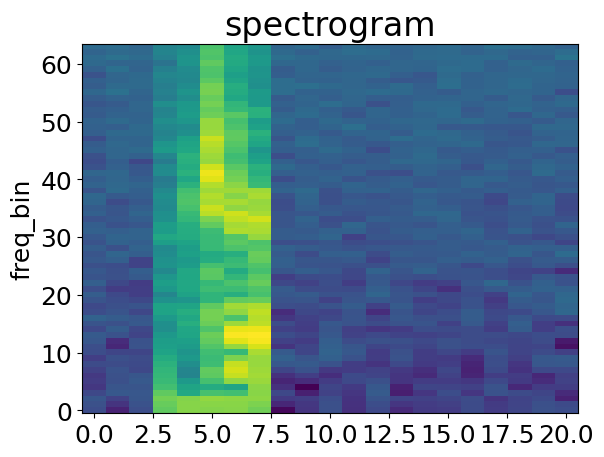

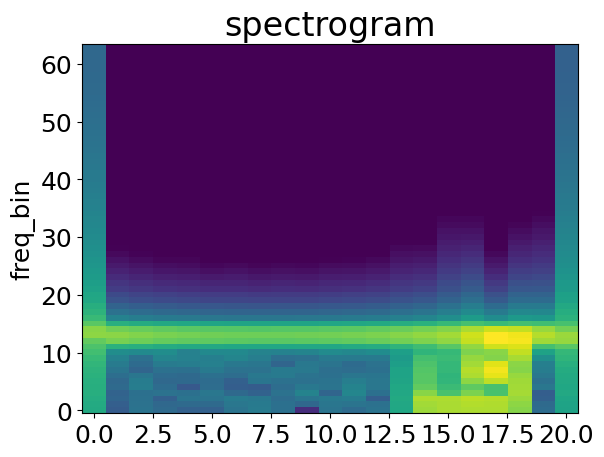

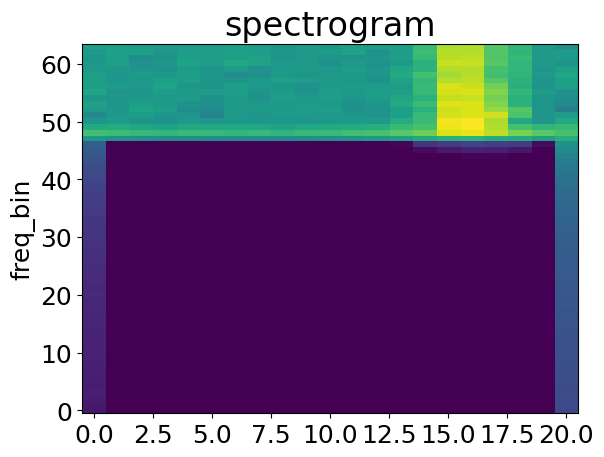

In [111]:
plot_spectrogram(normf_S_data[0], title="spectrogram"), plot_spectrogram(norml_S_data[0], title="spectrogram"), plot_spectrogram(normh_S_data[0], title="spectrogram")

(None, None, None)

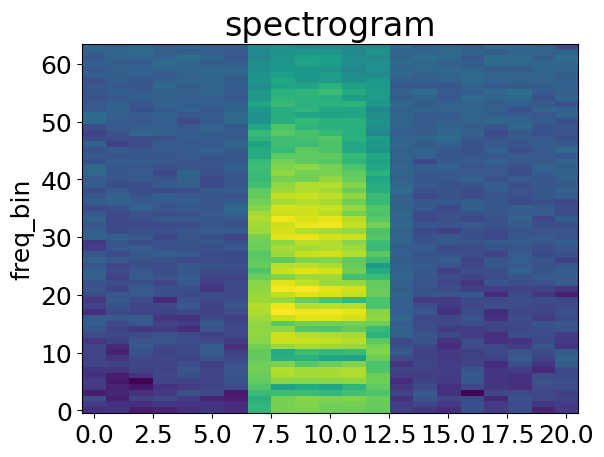

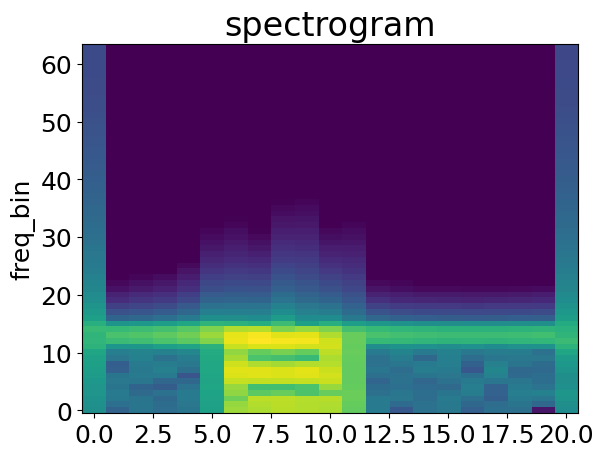

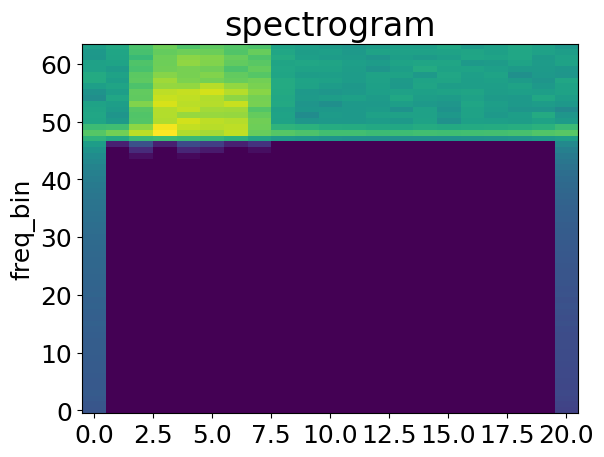

In [91]:
plot_spectrogram(normf_S_data[0], title="spectrogram"), plot_spectrogram(norml_S_data[0], title="spectrogram"), plot_spectrogram(normh_S_data[0], title="spectrogram")

In [7]:
with open(os.path.join(src_, "no-stress-seg.dict"), "rb") as file:
    # Load the object from the file
    mylist = pickle.load(file)
    mylist.remove('AH') # we don't include this, it is too mixed. 
select = mylist
mymap = TokenMap(mylist)

In [9]:
model_save_dir = os.path.join(model_save_, "H12-00000000001")

In [10]:
valid_ds = ThisDataset(strain_cut_audio_, 
                    os.path.join(suse_, "guide_validation.csv"), 
                    select=select, 
                    mapper=mymap,
                    transform=mytrans)
valid_ds_indices = DS_Tools.read_indices(os.path.join(model_save_dir, f"valid.use"))
use_valid_ds = torch.utils.data.Subset(valid_ds, valid_ds_indices)
valid_loader = DataLoader(use_valid_ds, batch_size=TrainingConfigs.BATCH_SIZE, 
                        shuffle=False, 
                        num_workers=TrainingConfigs.LOADER_WORKER)

In [12]:
for idx, (x, y) in enumerate(valid_loader):
    print(x.shape)
    raise Exception

torch.Size([64, 1, 64, 21])


Exception: 

In [30]:
class SmallNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(16), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2), 
        )
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin_1 = nn.Sequential(
            nn.Linear(16 * 32 * 10, 128),  # Reduced size
            nn.Dropout(0.5),  # Adjusted dropout rate
            nn.BatchNorm1d(128),
            nn.ReLU(),
            # nn.Linear(128, 64),  # Reduced size
        )
        self.lin = nn.Linear(in_features=128, out_features=38)

        self.conv.apply(self.init_conv_weights)
        self.lin.apply(self.init_lin_weights)

    def init_lin_weights(self, m):
        if isinstance(m, nn.Linear):
            # torch.nn.init.xavier_normal_(m.weight)
            torch.nn.init.kaiming_normal_(m.weight, a=0.1)
            m.bias.data.fill_(0.01)
    
    def init_conv_weights(self, m):
        if isinstance(m, nn.Conv2d):
            torch.nn.init.kaiming_normal_(m.weight, a=0.1)
            m.bias.data.zero_()

    def forward(self, x):
        x = self.conv(x)
        # x = self.ap(x)
        # x = x.view(x.shape[0], -1)
        x = x.view(x.shape[0], -1)
        x = self.lin_1(x)
        x = self.lin(x)
        return x

    def predict_on_output(self, output): 
        output = nn.Softmax(dim=1)(output)
        preds = torch.argmax(output, dim=1)
        return preds

class MediumNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(16), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.Conv2d(16, 64, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(64), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin_1 = nn.Sequential(
            nn.Linear(64 * 16 * 5, 128),  # Reduced size
            nn.Dropout(0.5),  # Adjusted dropout rate
            nn.BatchNorm1d(128),
            nn.ReLU(),
        )
        self.lin = nn.Linear(in_features=128, out_features=38)

        self.conv.apply(self.init_conv_weights)
        self.lin.apply(self.init_lin_weights)

    def init_lin_weights(self, m):
        if isinstance(m, nn.Linear):
            # torch.nn.init.xavier_normal_(m.weight)
            torch.nn.init.kaiming_normal_(m.weight, a=0.1)
            m.bias.data.fill_(0.01)
    
    def init_conv_weights(self, m):
        if isinstance(m, nn.Conv2d):
            torch.nn.init.kaiming_normal_(m.weight, a=0.1)
            m.bias.data.zero_()

    def forward(self, x):
        x = self.conv(x)
        # x = self.ap(x)
        # x = x.view(x.shape[0], -1)
        x = x.view(x.shape[0], -1)
        x = self.lin_1(x)
        x = self.lin(x)
        return x

    def predict_on_output(self, output): 
        output = nn.Softmax(dim=1)(output)
        preds = torch.argmax(output, dim=1)
        return preds
    
# Large Model
class LargeNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(16), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.Conv2d(16, 64, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(64), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(256), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin_1 = nn.Sequential(
            nn.Linear(256 * 8 * 2, 128), 
            nn.Dropout(0.5), 
            nn.BatchNorm1d(128),
            nn.ReLU(),
            # nn.Linear(512, 256),
        )
        self.lin = nn.Linear(in_features=128, out_features=38)

        self.conv.apply(self.init_conv_weights)
        self.lin.apply(self.init_lin_weights)

    def init_lin_weights(self, m):
        if isinstance(m, nn.Linear):
            # torch.nn.init.xavier_normal_(m.weight)
            torch.nn.init.kaiming_normal_(m.weight, a=0.1)
            m.bias.data.fill_(0.01)
    
    def init_conv_weights(self, m):
        if isinstance(m, nn.Conv2d):
            torch.nn.init.kaiming_normal_(m.weight, a=0.1)
            m.bias.data.zero_()

    def forward(self, x):
        x = self.conv(x)
        # x = self.ap(x)
        # x = x.view(x.shape[0], -1)
        x = x.view(x.shape[0], -1)
        x = self.lin_1(x)
        x = self.lin(x)
        return x

    def predict_on_output(self, output): 
        output = nn.Softmax(dim=1)(output)
        preds = torch.argmax(output, dim=1)
        return preds

In [31]:
summary(SmallNetwork(), input_size=(64, 1, 64, 21))

Layer (type:depth-idx)                   Output Shape              Param #
SmallNetwork                             [64, 38]                  --
├─Sequential: 1-1                        [64, 16, 32, 10]          --
│    └─Conv2d: 2-1                       [64, 16, 64, 21]          160
│    └─BatchNorm2d: 2-2                  [64, 16, 64, 21]          32
│    └─ReLU: 2-3                         [64, 16, 64, 21]          --
│    └─MaxPool2d: 2-4                    [64, 16, 32, 10]          --
├─Sequential: 1-2                        [64, 128]                 --
│    └─Linear: 2-5                       [64, 128]                 655,488
│    └─Dropout: 2-6                      [64, 128]                 --
│    └─BatchNorm1d: 2-7                  [64, 128]                 256
│    └─ReLU: 2-8                         [64, 128]                 --
├─Linear: 1-3                            [64, 38]                  4,902
Total params: 660,838
Trainable params: 660,838
Non-trainable params: 0
Tot

In [32]:
summary(MediumNetwork(), input_size=(64, 1, 64, 21))

Layer (type:depth-idx)                   Output Shape              Param #
MediumNetwork                            [64, 38]                  --
├─Sequential: 1-1                        [64, 64, 16, 5]           --
│    └─Conv2d: 2-1                       [64, 16, 64, 21]          160
│    └─BatchNorm2d: 2-2                  [64, 16, 64, 21]          32
│    └─ReLU: 2-3                         [64, 16, 64, 21]          --
│    └─MaxPool2d: 2-4                    [64, 16, 32, 10]          --
│    └─Conv2d: 2-5                       [64, 64, 32, 10]          9,280
│    └─BatchNorm2d: 2-6                  [64, 64, 32, 10]          128
│    └─ReLU: 2-7                         [64, 64, 32, 10]          --
│    └─MaxPool2d: 2-8                    [64, 64, 16, 5]           --
├─Sequential: 1-2                        [64, 128]                 --
│    └─Linear: 2-9                       [64, 128]                 655,488
│    └─Dropout: 2-10                     [64, 128]                 --
│    

In [33]:
summary(LargeNetwork(), input_size=(64, 1, 64, 21))

Layer (type:depth-idx)                   Output Shape              Param #
LargeNetwork                             [64, 38]                  --
├─Sequential: 1-1                        [64, 256, 8, 2]           --
│    └─Conv2d: 2-1                       [64, 16, 64, 21]          160
│    └─BatchNorm2d: 2-2                  [64, 16, 64, 21]          32
│    └─ReLU: 2-3                         [64, 16, 64, 21]          --
│    └─MaxPool2d: 2-4                    [64, 16, 32, 10]          --
│    └─Conv2d: 2-5                       [64, 64, 32, 10]          9,280
│    └─BatchNorm2d: 2-6                  [64, 64, 32, 10]          128
│    └─ReLU: 2-7                         [64, 64, 32, 10]          --
│    └─MaxPool2d: 2-8                    [64, 64, 16, 5]           --
│    └─Conv2d: 2-9                       [64, 256, 16, 5]          147,712
│    └─BatchNorm2d: 2-10                 [64, 256, 16, 5]          512
│    └─ReLU: 2-11                        [64, 256, 16, 5]          --
│   

In [3]:
model_save_dir = os.path.join(model_save_, "H20-0325204212-10")

In [8]:
tfs = DS_Tools.read_indices(os.path.join(model_save_dir, f"train_full.use"))
vfs = DS_Tools.read_indices(os.path.join(model_save_dir, f"valid_full.use"))

In [10]:
len(tfs) + len(vfs)

28139